In [5]:
import astropy
import astropy.table
import numpy
import matplotlib.pyplot as plt
import os
from astropy.table import join

In [6]:
x,y = 10,10

In [7]:
image_fn = "calexp-r-0-%d_%d.fi_image.fits" % (x,y)
print(image_fn)

calexp-r-0-10_10.fi_image.fits


In [8]:
catalog_fn = "calexp-r-0-%d-%d__catalog.fits" % (x,y)
print(catalog_fn)

calexp-r-0-10-10__catalog.fits


In [9]:
if (not os.path.isfile(catalog_fn)):
    sex_cmd = """sex -c sex.conf -CATALOG_NAME %s %s""" % (catalog_fn, image_fn)
    print(sex_cmd)
    os.system(" ".join(sex_cmd.split()))

In [15]:
fn = "6_8.vot"

In [16]:
table = astropy.table.Table.read(catalog_fn, format='fits')

In [17]:
table

ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAGERR_AUTO,FWHM_IMAGE,NUMBER,FLUX_RADIUS [2],MAGERR_APER [3],MAG_APER [3],FLAGS,PETRO_RADIUS,ISOAREA_IMAGE,MU_MEAN_MODEL,MU_EFF_MODEL,SPHEROID_SERSICN
deg,deg,mag,mag,pix,,pix,mag,mag,,,pix2,mag / arcsec2,mag / arcsec2,
float64,float64,float32,float32,float32,int32,float32,float32,float32,int16,float32,int32,float32,float32,float32
156.2471977,-35.0299043,23.8217,0.1112,11.88,1,6.962 .. 14.930,0.1149 .. 0.1189,25.5314 .. 24.7112,27,3.50,32,28.9991,30.1443,2.576
156.1962962,-35.0295765,24.2729,0.0778,3.46,2,1.701 .. 2.657,0.0563 .. 0.0852,24.5717 .. 24.2254,26,5.94,36,26.3666,27.0878,1.046
155.9114084,-35.0281713,24.8302,0.1466,8.26,3,2.380 .. 4.833,0.1223 .. 0.1492,25.5098 .. 24.9109,27,3.96,27,26.8008,27.8708,2.130
156.0146160,-35.0287557,24.6544,0.1149,5.35,4,1.763 .. 3.207,0.0835 .. 0.1248,25.0502 .. 24.6867,27,3.50,29,17.6149,17.8468,0.315
155.8377736,-35.0275798,23.6738,0.0579,6.34,5,2.051 .. 3.512,0.0396 .. 0.0539,24.1791 .. 23.7208,25,5.28,56,26.3411,27.2509,1.560
156.0486941,-35.0289372,23.4305,0.0492,6.80,6,2.187 .. 3.959,0.0332 .. 0.0417,24.0423 .. 23.4930,26,5.28,50,26.3776,26.8176,0.554
155.7830215,-35.0272399,23.7364,0.0619,8.40,7,1.802 .. 3.025,0.0354 .. 0.0522,24.1070 .. 23.7315,27,3.96,55,25.3013,25.9479,0.895
156.0592654,-35.0286179,25.2907,0.2389,6.35,8,1.414 .. 1.959,0.1034 .. 0.2854,25.2139 .. 25.3700,25,5.28,31,25.2234,26.9724,7.864


In [9]:
table['RADIUS_HALFLIGHT'] = table['FLUX_RADIUS'][:,0]

In [10]:
pixel_to_arcsec = 0.333

In [11]:
arcsec_to_kpc = 0.210
# for a distance of 43.2 Mpc

In [12]:
table['HALF_LIGHT_RADIUS_KPC'] = table['RADIUS_HALFLIGHT'] * pixel_to_arcsec * arcsec_to_kpc

In [13]:
table['FWHM_ARCSEC'] = table['FWHM_IMAGE'] * pixel_to_arcsec

In [14]:
min_radius = 1. # kpc

# convert kpc first to arcseconds, then from arcsec to pixels
# area then is pi * r**2
min_radius_pixels  = (min_radius / arcsec_to_kpc / pixel_to_arcsec)
print(min_radius_pixels)

min_isoarea = 3.14 * min_radius_pixels**2
print(min_isoarea)

14.300014300014299
642.0998841991262


In [15]:
# poor persons approach

# undoing what sextractor does internally
# mag = -2.5*log10(flux) + magzero

magzero = 27
instrumental_magnitude = table["MAG_AUTO"] - magzero
instrumental_counts = numpy.power(10., instrumental_magnitude / -2.5)

halflight_area_pixels = 3.14 * table['RADIUS_HALFLIGHT']**2

# half-flux divided by halflight_area
mean_surface_brightness_counts_per_pixel = 0.5 *  instrumental_counts / halflight_area_pixels

# convert that back from counts/pixel to mag/arcsec
mean_surface_brightness_per_arcsec2 = (mean_surface_brightness_counts_per_pixel / pixel_to_arcsec**2)
mean_surface_brightness_mags_arcsec2 = -2.5*numpy.log10(mean_surface_brightness_per_arcsec2) + magzero

table['MEAN_SURF_BRIGHTNESS'] = mean_surface_brightness_mags_arcsec2

/tmp/ipykernel_7070/2983251773.py:13: RuntimeWarning: divide by zero encountered in divide
  mean_surface_brightness_counts_per_pixel = 0.5 *  instrumental_counts / halflight_area_pixels


(0.0, 2.0)

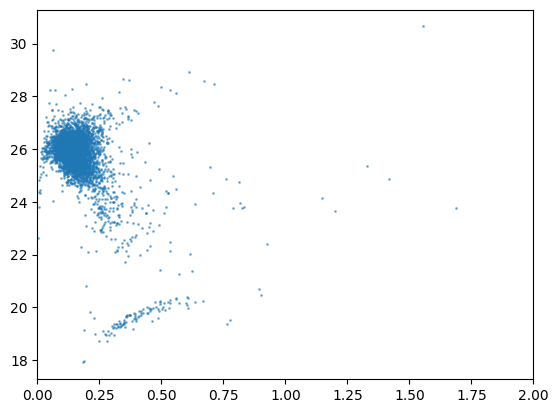

In [16]:
fig,ax = plt.subplots()

valid_data = (table['RADIUS_HALFLIGHT'] > 0) & (table["MAG_AUTO"] < 50) & (table["FWHM_IMAGE"] > 8)
# ax.scatter(table['HALF_LIGHT_RADIUS_KPC'], table['MEAN_SURF_BRIGHTNESS'], s=1)
ax.scatter(table['HALF_LIGHT_RADIUS_KPC'][valid_data], table['MEAN_SURF_BRIGHTNESS'][valid_data], s=1, alpha=0.5)
# ax.scatter(table['RADIUS_HALFLIGHT'][valid_data], table['FWHM_IMAGE'][valid_data], s=1, alpha=0.1)
ax.set_xlim((0,2))
#ax.set_ylim((8,20))

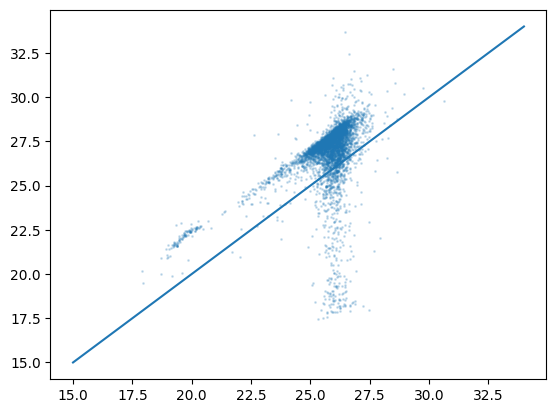

In [17]:
fig,ax = plt.subplots()
valid_data = (table['RADIUS_HALFLIGHT'] > 0) & (table["MAG_AUTO"] < 50) & (table["FWHM_IMAGE"] > 8)
ax.scatter(table['MEAN_SURF_BRIGHTNESS'][valid_data], table['MU_MEAN_MODEL'][valid_data], s=1, alpha=0.2)
ax.plot(numpy.arange(15,35), numpy.arange(15,35))

In [18]:
len(table)

16096

In [19]:
is_udg_candidate = \
    (table['HALF_LIGHT_RADIUS_KPC'] > 0.65) & \
    (table['MAG_AUTO'] < 27) & \
    (table['FWHM_ARCSEC'] > 2.65) &\
    (table['MU_MEAN_MODEL'] > 23.33) & (table['MU_MEAN_MODEL'] < 29) & \
    (table['ISOAREA_IMAGE'] > min_isoarea)
#& \
#    (table['ISOAREA_IMAGE'] > min_isoarea) 
#    (table['MU_MEAN_MODEL'] > 23.33) & (table['MU_MEAN_MODEL'] < 29)

udg_candidates = table[is_udg_candidate]
print(len(udg_candidates))

#     (table['ISOAREA_IMAGE'] > min_isoarea)

15


In [20]:
udg_candidates.write("udg_candidates__%d-%d.vot" % (x,y), format='votable', overwrite=True)

In [21]:
#turn fits1.0 back into .vot file
table.write("calexp-r-0-%d-%d__catalog.vot" % (x,y), format='votable', overwrite=True)

In [22]:
from astropy.table import join